In [ ]:
!python --version
!date

Python 3.11.12
Thu May 22 07:49:28 AM UTC 2025


# JGLUE（日本語言語理解ベンチマーク）

## 注意
### GPUを指定する
LLMを用いた学習を行っている都合上、デフォルト（CPU）実行すると極めて時間がかかる。おそらく数時間要するだろう。自身でも動作確認したい人は、GPUを指定して実行することをお勧めする。

GPUを指定するには以下の手順を取る。

- 「ランタイム」から「ランタイムのタイプの変更」を選ぶ。
- 「ハードウェア アクセラレータ」からGPUを選ぶ。
  - T4 GPU を選ぶと良い。この中では低スペックだが十分早い。T4 GPUなら、1エポックの学習が約15分で終了する。

### リソース使用制限
Google Colabは無料で利用できるが、利用度合いに応じてリソースが制限されることがある。特にGPUは使えなくなることが多いため、不必要に何度も実行することは避けよう。

詳細: [最適な Colab のプランを選択する](https://colab.research.google.com/signup/pricing?hl=ja)

## 前提
- [report4_preprocessing.ipynb](./report4_preprocessing.ipynb)を実行すると前処理された3つのpklファイル（preprocessed_{train,val,test}.pkl）が作成される。この3つのファイルをPCにダウンロードしておき、本コードを実行する環境で参照できるようにアップロードすること。
- `utils.py` も別途アップロードすること。

## 環境構築

In [ ]:
!pip install fugashi[unidic-lite]
!pip install accelerate -U

# 2025年5月22日現在: datasetsが古く、numpy2系列とブッキングするようです。
!pip install --upgrade datasets

## 前処理済みデータの読み込み

In [ ]:
from utils import *

# 前処理済みデータ読み込み
df_train = get_data("preprocessed_train.pkl")
df_val = get_data("preprocessed_val.pkl")
df_test = get_data("preprocessed_test.pkl")

# 中身の確認
df_train.head()

,sent1,sent2,bow,w2v,label
0,二人の男性がジャンボジェット機を見ています。,2人の男性が、白い飛行機を眺めています。,二人 の 男性 が ジャンボジェット 機 を 見 て い ます 。 [SEP] 2人 の 男...,"[0.050462592, -0.13604076, 0.010860913, -0.197...",2
1,2人の男性が、白い飛行機を眺めています。,二人の男性がジャンボジェット機を見ています。,2人 の 男性 が 、 白い 飛行機 を 眺め て い ます 。 [SEP] 二人 の 男性...,"[0.088041924, -0.08648207, 0.014981923, -0.196...",2
2,男性が子供を抱き上げて立っています。,坊主頭の男性が子供を抱いて立っています。,男性 が 子供 を 抱き上げ て 立っ て い ます 。 [SEP] 坊主頭 の 男性 が ...,"[0.056786165, -0.1304283, 0.013041455, -0.1172...",2
3,坊主頭の男性が子供を抱いて立っています。,男性が子供を抱き上げて立っています。,坊主頭 の 男性 が 子供 を 抱い て 立っ て い ます 。 [SEP] 男性 が 子供...,"[0.042833548, -0.12648883, 0.002992845, -0.119...",0
4,草地の上で牛と男性が立っています。,農場で白い牛が男性の隣に立っています。,草地 の 上 で 牛 と 男性 が 立っ て い ます 。 [SEP] 農場 で 白い 牛 ...,"[0.13754506, -0.074033, 0.013317642, -0.165398...",2


In [ ]:
# データセット毎のラベル分布チェック

import collections
print("train_labels: ", collections.Counter(df_train["label"]))
print("val_labels: ", collections.Counter(df_val["label"]))
print("test_labels: ", collections.Counter(df_test["label"]))

train_labels:  Counter({2: 11193, 1: 6004, 0: 2876})
val_labels:  Counter({2: 1350, 1: 735, 0: 349})
test_labels:  Counter({2: 1365, 1: 776, 0: 367})


## case 3: BERT + classification
### データセットの準備
Transformerのデファクトスタンダードとなっている Huggingface Datasets 型としてデータを用意すると諸々の処理を楽に実行することができる。このため、pandasのデータフレーム型から Datasets 型に変換し直している。

In [ ]:
# ===============================
# ✅ ライブラリ
# ===============================
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import torch

# ===============================
# ✅ Dataset構築
# ===============================
def create_dataset(sent1, sent2, labels):
    data = {
        "sentence1": sent1,
        "sentence2": sent2,
        "labels": labels
    }
    return Dataset.from_dict(data)

train_ds = create_dataset(df_train["sent1"], df_train["sent2"], df_train["label"])
val_ds = create_dataset(df_val["sent1"], df_val["sent2"], df_val["label"])
test_ds = create_dataset(df_test["sent1"], df_test["sent2"], df_test["label"])

print(f"{train_ds[0]=}")

train_ds[0]={'sentence1': '二人の男性がジャンボジェット機を見ています。', 'sentence2': '2人の男性が、白い飛行機を眺めています。', 'labels': 2}


## LLM用の前処理

### LLM用にデータを整形
- トークン系列分用意するデータ（同じ長さで揃える必要がある）
  - `input_ids`: 入力文をトークナイズした結果（トークンのID列）。
  - `tokey_type_ids`: BERT系では2文の対で用意することを前提としている。その2文を区別するためのフィルタ設定。単一文の場合は全て0（今回はこれ）。2文ある場合、文2のトークンは1になる。
  - `attention_mask`: 一般的には「どのトークンに注意を向けるか」を0（無視する）,1（注意を向ける）で設定している。ここでは実トークンがある部分を1に、パディングで意味の無い部分を0として設定している。
  - `labels`: Trainerと連動した設定。train_dataset=train_enc と設定していると、train_enc内の"labels"を自動で参照し、損失を計算するようになっている。違う名目でラベルを設定したい場合には DataCollatorもしくはTrainerをカスタマイズする必要があります。

### モデルの用意
- ここでは "tohoku-nlp/bert-base-japanese-v3" を利用。
- 長文だが、最初の出力「`Some weights of BertForSequenceClassification were not initialized from the model checkpoint at tohoku-nlp/bert-base-japanese-v3 and are newly initialized: ['classifier.bias', 'classifier.weight']   You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.`」は、このままでは利用できない（ので学習が必要だろう）ということを指摘している。この理由は、[AutoModelForSequenceClassification](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForSequenceClassification.from_pretrained)が「LLMの最後尾に新たな線形層（[torch.nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)）を追加しているためだ。この線形層はクラス数と同数のユニットを持つように設定されており（引数num_labelsで設定）、各ユニットに対するスコアを求めるようにモデルを拡張している。
- このようなにモデルを拡張しているということは、拡張した部分（Linear層のパラメータ）については重みがまっさらな状態である。このままでは当然推定できない（でたらめになる）ため、「You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.」と注意を促している。


In [ ]:
# GPUチェック（ない場合はCPU実行）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔧 実行デバイス: {device}")

# ===============================
# ✅ モデル・トークナイザーを用意
# ===============================
model_name = "cl-tohoku/bert-base-japanese-v3"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
model.to(device) # GPU設定時にはGPU実行

# ===============================
# ✅ トークン化
# ===============================
def tokenize_function(examples):
    return tokenizer(examples["sentence1"], examples["sentence2"],
                     padding="max_length", truncation=True, max_length=128)

train_enc = train_ds.map(tokenize_function, batched=True)
val_enc = val_ds.map(tokenize_function, batched=True)
test_enc = test_ds.map(tokenize_function, batched=True)

print(f"before: {type(train_enc[0])=}")
print(f"before: {train_enc[0]=}")

# LLMへの入力形式に変換。
# - Hugging Face の Dataset オブジェクトを、PyTorch tensor 形式に変換
#   元データは dict 型。
#   これを input_ids, attention_mask, labels を含む tensor に変換。
#   input_ids: 入力文のトークンid系列。
#
train_enc.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_enc.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_enc.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

#print(f"after: {train_enc[0]=}")
#print(f"after: {type(train_enc[0])=}")
#print(f"after: {train_enc.with_format('python')[0]=}")

🔧 実行デバイス: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-v3 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/20073 [00:00<?, ? examples/s]

Map:   0%|          | 0/2434 [00:00<?, ? examples/s]

Map:   0%|          | 0/2508 [00:00<?, ? examples/s]

before: type(train_enc[0])=<class 'dict'>
before: train_enc[0]={'sentence1': '二人の男性がジャンボジェット機を見ています。', 'sentence2': '2人の男性が、白い飛行機を眺めています。', 'labels': 2, 'input_ids': [2, 14269, 464, 13341, 430, 27914, 16753, 3107, 500, 5538, 456, 422, 12995, 385, 3, 33, 680, 464, 13341, 430, 384, 16517, 13208, 3107, 500, 29887, 456, 422, 12995, 385, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
tokenizer.decode([2, 14269,   464, 13341])

'[CLS] 二人 の 男性'

## 学習
ステップ毎に出力しているログは、学習データに対する損失(training loss)、検証データに対する損失(validation loss)。

ログを確認すると、学習データに対する損失が途中で頭打ちになっているように見える。しかし検証データに対してはまだ若干改善し続けているようにも見えるため、過学習かどうかは判断しづらい。ここでは特別なことはせずに指定したエポック数の学習を続け、最終モデルを用いた検証を行うこととした。

- TrainingArgumentsの補足
  - 設定可能な項目多数のため、詳細は[huggingfaceの公式ドキュメント](https://huggingface.co/docs/transformers/ja/main_classes/trainer)推奨。コード内では利用したパラメータだけ補足している。

In [ ]:
from transformers import TrainerCallback

# ログ記録用
train_log_history = []

class LoggingCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            logs["step"] = state.global_step
            train_log_history.append(logs.copy())

# ===============================
# ✅ 学習設定
# ===============================
training_args = TrainingArguments(
    output_dir="./results",         # 出力フォルダ
    per_device_train_batch_size=16, # 学習時のバッチサイズ
    per_device_eval_batch_size=32,  # テスト時のバッチサイズ
    num_train_epochs=1,             # エポック数
    eval_strategy="steps",          # eval_datasetによる評価タイミング（ステップ毎）
    eval_steps=100,                 # 評価タイミング
    logging_strategy="steps",       # ログ（loss, learning_rate, epoch等）生成タイミング（ステップ毎）
    logging_steps=100,              # ログ生成ステップ数
    save_strategy="no",             # 学習中にcheckpointを保存しない
    report_to="none"                # wandb等への出力をしない
)

# ===============================
# ✅ 学習 & 評価
# ===============================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_enc,
#    train_dataset=test_enc, # 動作確認時のみ利用
    eval_dataset=val_enc,
    tokenizer=tokenizer,
    callbacks=[LoggingCallback()] # ログ用コールバック
)

trainer.train()

<ipython-input-33-1f8dc0ca4561>:31: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



Step,Training Loss,Validation Loss,
100,0.263500,0.418176,100
200,0.217500,0.563925,200
300,0.225600,0.481815,300
400,0.194600,0.515818,400
500,0.205000,0.534839,500
600,0.130400,0.520754,600
700,0.181200,0.479634,700
800,0.168200,0.476028,800
900,0.140100,0.455427,900
1000,0.159400,0.483843,1000


TrainOutput(global_step=1255, training_loss=0.19688097509254973, metrics={'train_runtime': 643.8758, 'train_samples_per_second': 31.175, 'train_steps_per_second': 1.949, 'total_flos': 1320368908513536.0, 'train_loss': 0.19688097509254973, 'epoch': 1.0, 'step': 1255})

In [ ]:
# train_log_historyへのログ保存方法確認
train_log_history[:5]

[{'loss': 0.2635,
  'grad_norm': 4.145387649536133,
  'learning_rate': 4.605577689243028e-05,
  'epoch': 0.0796812749003984,
  'step': 100},
 {'eval_loss': 0.41817551851272583,
  'eval_runtime': 16.6703,
  'eval_samples_per_second': 146.008,
  'eval_steps_per_second': 4.619,
  'epoch': 0.0796812749003984,
  'step': 100},
 {'loss': 0.2175,
  'grad_norm': 11.141556739807129,
  'learning_rate': 4.2071713147410365e-05,
  'epoch': 0.1593625498007968,
  'step': 200},
 {'eval_loss': 0.5639246106147766,
  'eval_runtime': 16.9137,
  'eval_samples_per_second': 143.907,
  'eval_steps_per_second': 4.553,
  'epoch': 0.1593625498007968,
  'step': 200},
 {'loss': 0.2256,
  'grad_norm': 19.625856399536133,
  'learning_rate': 3.808764940239044e-05,
  'epoch': 0.23904382470119523,
  'step': 300}]

In [ ]:
# 学習曲線の描画
import pandas as pd
import plotly.graph_objects as go

# ログ履歴（train_log_history）は Trainer実行時に記録されたものを前提
log_df = pd.DataFrame(train_log_history)

# train log と eval log が混在しているため、分割
log_train_df = log_df[log_df["loss"].notna()]
log_eval_df  = log_df[log_df["eval_loss"].notna()]

# 描画オブジェクト
fig = go.Figure()

# Train Loss
if "loss" in log_df.columns:
    fig.add_trace(go.Scatter(x=log_train_df["step"], y=log_train_df["loss"],
                             mode='lines+markers', name='Train Loss'))

# Eval Loss
if "eval_loss" in log_df.columns:
    fig.add_trace(go.Scatter(x=log_eval_df["step"], y=log_eval_df["eval_loss"],
                             mode='lines+markers', name='Eval Loss'))

# Eval Accuracy
if "eval_accuracy" in log_df.columns:
    fig.add_trace(go.Scatter(x=log_eval_df["step"], y=log_eval_df["eval_accuracy"],
                             mode='lines+markers', name='Eval Accuracy'))

# レイアウト
fig.update_layout(
    title="Training & Evaluation Metrics",
    xaxis_title="Training Step",
    yaxis_title="Metric Value",
    legend_title="Metrics",
    template="plotly_white"
)

fig.show()


=== BERT Fine-tuned ===
               precision    recall  f1-score   support

   entailment       0.71      0.72      0.72       367
contradiction       0.93      0.88      0.90       776
      neutral       0.89      0.91      0.90      1365

     accuracy                           0.87      2508
    macro avg       0.84      0.84      0.84      2508
 weighted avg       0.88      0.87      0.87      2508



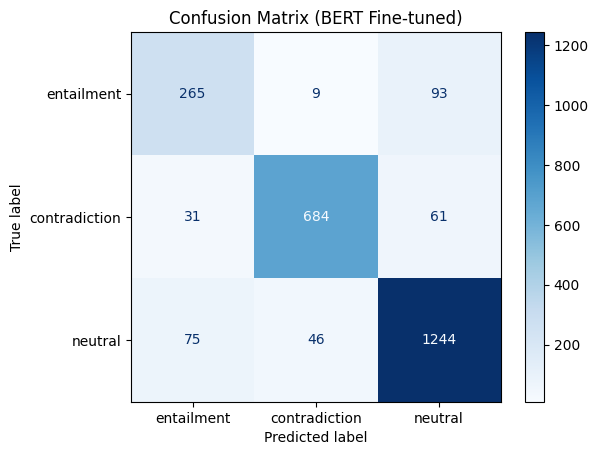

In [ ]:
# ===============================
# ✅ 評価結果 + 混同行列
# ===============================
from sklearn.metrics import classification_report

pred_result = trainer.predict(test_enc)
pred_bert = pred_result.predictions.argmax(axis=1)

print("=== BERT Fine-tuned ===")
print(classification_report(df_test["label"],
                            pred_bert,
                            target_names=label2id.keys()))
plot_confusion("BERT Fine-tuned",
               df_test["label"],
               pred_bert,
               labels=list(label2id.keys()))

In [ ]:
# 検証データに対する失敗事例分析
# trainer.predictでは「ラベルに対する確信度スコア」が出力されるだけであり、ラベルにはなっていない。
# 確信度スコアから最大確信度（argmax）となるインデックス（=予測ラベル）に変換してから分析する必要がある。
pred_bert = trainer.predict(val_enc)
pred_bert_val = pred_bert.predictions.argmax(axis=1)
print(f"{pred_bert_val[0]=}")

mis_df = show_misclassified_examples(
    df_val["sent1"], df_val["sent2"], df_val["label"], pred_bert_val, id2label
)

mis_df

pred_bert_val[0]=np.int64(2)


,sent1,sent2,true_label,pred_label,true_label_name,pred_label_name
0,トランクのなかでネコが伏せています。,トランクのなかでねこが伏せています。,0,1,entailment,contradiction
1,木々の生える草原を歩く小さい小象と大きい象がいます。,広い草原の中に２頭の象が歩いている。,0,2,entailment,neutral
2,黒い犬に寄り掛かっているテディベア。,黒い犬に熊のぬいぐるみがもたれさせてあります。,0,2,entailment,neutral
3,線路上で鉄道車両が通過待ちをしています。,線路上を鉄道車両が通過するところです。,1,0,contradiction,entailment
4,駅構内に消火栓が設置されています。,草地の中に消火栓が設置されています。,1,2,contradiction,neutral
5,駅のプラットホームを電車が進んでいます。,駅のプラットホームに電車が停車しています。,1,0,contradiction,entailment
6,クマがコンクリートの上に座っています。,クマが壁にもたれて座っています。,2,1,neutral,contradiction
7,子どもたちがテーブルの前で食事をしています。,子供たちがケーキを前に笑っています。,2,1,neutral,contradiction
8,ピンクの服を着た人と緑色の服を着た人の前の机に箱に入ったドーナツが置かれています。,ドーナツの前で女性が男性と話しています。,2,1,neutral,contradiction


In [ ]:
# 検証データに対する全失敗事例をExcelファイルとして出力

true_label = df_val["label"].map(id2label)
pred_label = pd.Series(pred_bert.label_ids).map(id2label)

mis_all_df = pd.DataFrame({
    "sent1":df_val["sent1"],
    "sent2":df_val["sent2"],
    "true_label":df_val["label"],
    "bert_pred_label":pred_bert.label_ids,
    "true_label_name":true_label,
    "bert_pred_label_name":pred_label
})

mis_all_df.to_excel("mis_all_df_bert.xlsx")